In [4]:
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
night=Image.open('vangogh-starry-night.png')

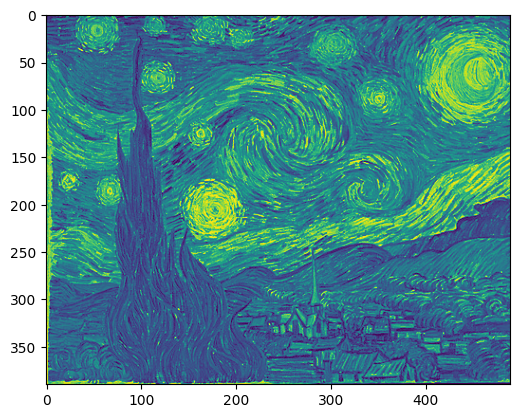

In [5]:
plt.imshow(night)